<a href="https://colab.research.google.com/github/Azimoj/Classifier-automatiquement-des-biens-de-consommation/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The "Marketplace" company is launching an e-commerce marketplace where sellers offer items by posting a photo and description. Currently the categorization of the small number of products is done manually. The e-commerce site aims to expand and significantly increase the number of products, and manual categorization would be a long and unreliable step. To facilitate the posting of new articles and the search for products, it becomes necessary to automate this task. This categorization will be done from the descriptions and images of the products.

La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

### **Text Analysis**

https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

In [4]:
pip install "gensim==3.8.1"

     |████████████████████████████████| 24.2 MB 44.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Corpus Processing
import nltk
nltk.download('stopwords')
import string
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#from nltk import SnowballStemmer,PorterStemmer
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

from sklearn.metrics import adjusted_rand_score

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import    gensim
from gensim import corpora
from pprint  import pprint
import  gensim.downloader
from gensim import matutils, utils
from gensim.corpora                   import Dictionary

from gensim.models                    import CoherenceModel
from gensim.models                    import LdaModel
from gensim.models                    import TfidfModel

from gensim.parsing.preprocessing     import preprocess_string

In [8]:
#Download databases
flipkart= pd.read_csv('/content/drive/MyDrive/p6/flipkart_com-ecommerce_sample_1050.csv',sep=',')
flipkart.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [9]:
data_con=flipkart.copy()

In [10]:
del data_con['is_FK_Advantage_product']  # Boolean
del data_con['crawl_timestamp']

In [11]:
data_con['uniq_id'].duplicated().sum()

0

In [12]:
data_con.shape

(1050, 13)

In [13]:
data_con.isnull().sum()

uniq_id                     0
product_url                 0
product_name                0
product_category_tree       0
pid                         0
retail_price                1
discounted_price            1
image                       0
description                 0
product_rating              0
overall_rating              0
brand                     338
product_specifications      1
dtype: int64

 ***We have some missing values!!***

---



### **Missing values and imputation**

In [14]:
import missingno as msno

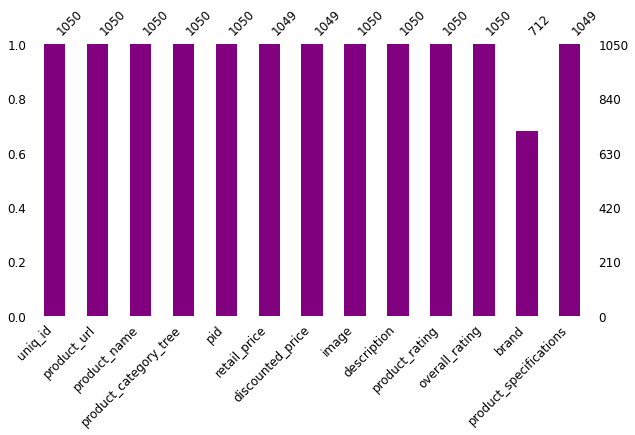

In [15]:
msno.bar(data_con,  figsize=(10,5), fontsize=12, color="purple")

there is missing value for 'retail_price' , 'discounted_price' , 'brand' & 'product_specifications'

**Imputation**

In [16]:
data_con['retail_price'].fillna((data_con['retail_price'].median()), inplace=True)
data_con['discounted_price'].fillna((data_con['discounted_price'].median()), inplace=True)

In [17]:
data_con['brand'].fillna((data_con['brand'].mode()[0]), inplace=True)
data_con['product_specifications'].fillna((data_con['product_specifications'].mode()[0]), inplace=True)

In [18]:
data_con.isnull().sum()

uniq_id                   0
product_url               0
product_name              0
product_category_tree     0
pid                       0
retail_price              0
discounted_price          0
image                     0
description               0
product_rating            0
overall_rating            0
brand                     0
product_specifications    0
dtype: int64

### **Data Exploration**

In [19]:
data = data_con.filter(items=['uniq_id','image', 'product_name', 'product_category_tree', 'description'])

## **Cleaning dataset & visualisation**

### Product Name

In [20]:
data['product_name'].unique()

array(['Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
       'Sathiyas Cotton Bath Towel',
       'Eurospa Cotton Terry Face Towel Set', ...,
       'Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker',
       'Wallmantra Medium Vinyl Sticker Sticker',
       'Uberlyfe Large Vinyl Sticker'], dtype=object)

In [21]:
data['product_category_tree'].sample(5)

89     ["Home Decor & Festive Needs >> Showpieces >> ...
971    ["Baby Care >> Baby Bedding >> Baby Bedsheets ...
584    ["Watches >> Wrist Watches >> Fastrack Wrist W...
692    ["Beauty and Personal Care >> Body and Skin Ca...
920    ["Home Furnishing >> Bed Linen >> Blankets, Qu...
Name: product_category_tree, dtype: object

In [22]:
data['description'].sample(5)

881    Sassoon Cotton Bath Towel (Red)\r\n           ...
379    Buy Netgear AC 750 Wi-Fi Range Extender only f...
362    Flipkart.com: Buy Vincent Valentine Paris Set ...
415    Flipkart.com: Buy Ajmal Titanium and Expeditio...
243    Buy Suruchi Kadhai 4.5 L for Rs.965 online. Su...
Name: description, dtype: object

**Cleaning 'product_category_tree' column**

In [23]:
data['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [24]:
data['category']=data['product_category_tree'].str.split(
    pat=">>",expand=True)[0]
data["category"] = data["category"].str.replace('[', "")
data["category"] = data["category"].str.replace('"', "")
data["category"] = data["category"].str.replace(' ', "")

catg  = {'HomeFurnishing':'Home',
         'HomeDecor&FestiveNeeds':'Decor',
         'Watches':'Watches',
         'BabyCare':'Baby',
         'BeautyandPersonalCare':'Beauty',
         'Computers':'Computers',
         'Kitchen&Dining':'Kitchen'}
data['category'] =[catg[i] for i in data['category']]
cluster  = {'Baby':0,
           'Decor':1,
           'Computers':2,
           'Watches':3,
           'Kitchen':4,
           'Home':5,
           'Beauty':6}

label_category = data['category'].map(cluster)
data["label_category"] = label_category

In [25]:
data['category_1']=data['product_category_tree'].str.split(
    pat=">>",expand=True)[1]
data["category_1"] = data["category_1"].str.replace('[', "")
data["category_1"] = data["category_1"].str.replace('"', "")
data["category_1"] = data["category_1"].str.replace(' ', "")

In [26]:
data['category'].value_counts()

Baby         150
Computers    150
Beauty       150
Watches      150
Decor        150
Kitchen      150
Home         150
Name: category, dtype: int64

In [27]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
uniq_id,1050,1050,c1e9b5875e442203073211c522072973,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image,1050,1050,11f06dffebf7edf9e15351834a190c2c.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,1050,1050,Aapno Rajasthan Princess Design Showpiece - ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category_tree,1050,642,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1050,1050,Flipkart.com is offering HoA Baby Nappy Set of...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1050,7,Baby,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label_category,1050,NaN,NaN,NaN,3,2.00095,0,1,3,5,6
category_1,1050,63,WristWatches,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data.drop('product_category_tree',inplace=True, axis=1)

In [29]:
data.head()

,uniq_id,image,product_name,description,category,label_category,category_1
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby,0,BabyBath&Skin
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home,5,BedLinen
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home,5,BedLinen


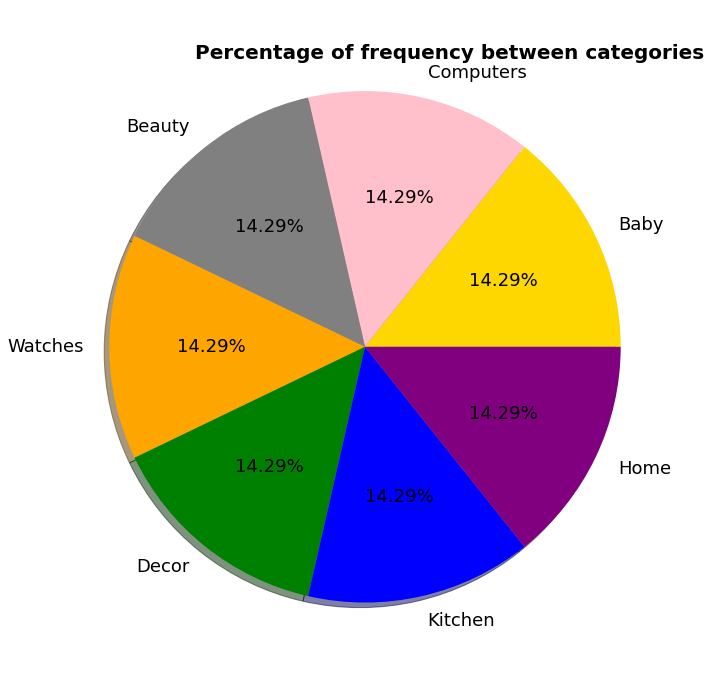

In [30]:
values = data['category'].value_counts()
labels = data['category'].value_counts().index
colors = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple']
explode = (0, 0, 0, 0, 0, 0, 0)

# Plot
plt.figure(figsize=(10, 10))
plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 18})

ttl = plt.title( "Percentage of frequency between categories",  fontweight = 'bold' ,fontsize=20,pad=50)

ttl.set_position([0.65, 0.85])
plt.axis('equal')
plt.tight_layout()

In [31]:
pd.set_option('display.max_row',62)
data['category_1'].value_counts().head(20)
#Nous avons 62 catégories 
#c'est plus détaille que les categories de la colonne cat_lvl1

WristWatches                149
LaptopAccessories            87
InfantWear                   84
CoffeeMugs                   74
Showpieces                   71
Fragrances                   65
BedLinen                     65
NetworkComponents            49
TableDecor&Handicrafts       27
Cookware                     27
CombosandKits                24
WallDecor&Clocks             22
BathLinen                    21
Curtains&Accessories         19
Makeup                       18
BodyandSkinCare              15
BabyBedding                  15
Baby&KidsGifts               15
DecorativeLighting&Lamps     14
KitchenTools                 14
Name: category_1, dtype: int64

### **Text Preprocessing**

* remove punctional
* keep only alphabetic characters
* remove stopwords and isolated letters
* put all words in lowercase
* lemmatization
* keep only the canonical forms of words



In [32]:
data['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [33]:
data['description'].sample(5)

444    Key Features of JBC Collection Cotton Printed ...
99     Buy Thar Handloom Stylish Multicolor Jewellery...
799    Buy Rajrang Animal Cushions Cover at Rs. 984 a...
527    Maxima 06362CMGY Gold Analog Watch  - For Men ...
589    Shopfloor.XYZ Vacuum Cleaner for Computers, La...
Name: description, dtype: object

In [34]:
len(data['description'])

1050

**Function for the number of words**

In [35]:
def word_size(base,columns):
  corpus=base[columns]

  words_dico=dict()
  import re
  #importation regular expressions

  expr = re.compile("\W+",re.U) # Regular expression of segmentation on spaces
  for text in corpus: # For each comment in the corpus
    x = str(text)
    text = expr.split(x)
    for word in set(text): # Retrieving each new word
      if word not in words_dico:
        words_dico[word]=1
      else: 
          # For each word already listed: add 1 if it is found
            words_dico[word]=words_dico[word]+1

  return len(words_dico)

In [36]:
size=word_size(data,'description')
print(size)


7671


In [37]:
size=word_size(data,'product_name')
print(size)

2531



$\color{orange}{\text{1- Lower word}}$







In [38]:
data["description_clean"] = data["description"].apply(lambda x: x.lower())
data["name_clean"] = data["product_name"].apply(lambda x: x.lower())

display(data.sample(2))

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean
190,b46d7b8e6826ad4c8b40a991da0f54d7,b46d7b8e6826ad4c8b40a991da0f54d7.jpg,Rockmantra Vintage Sea Evening Ceramic Mug,Buy Rockmantra Vintage Sea Evening Ceramic Mug...,Kitchen,4,CoffeeMugs,buy rockmantra vintage sea evening ceramic mug...,rockmantra vintage sea evening ceramic mug
998,78fcb634d9838127464d827234ab05ad,78fcb634d9838127464d827234ab05ad.jpg,Happiness Is Printed Bone China Mug,Key Features of Happiness Is Printed Bone Chin...,Kitchen,4,CoffeeMugs,key features of happiness is printed bone chin...,happiness is printed bone china mug


In [39]:
size=word_size(data,'description_clean')
print(size)

6086


In [40]:
size=word_size(data,'name_clean')
print(size)

2387


$\color{orange}{\text{2- Contraction}}$


we will or we shouldnt've -> we should not have.

In [41]:
!pip install contractions

     |████████████████████████████████| 284 kB 37.4 MB/s 
     |████████████████████████████████| 321 kB 62.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85449 sha256=c66494a23dc1fb1055ac5800fe6a06bcadbbdfeb25e929383d9304e893f88c40
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [42]:
import contractions
data["description_clean"] = data["description_clean"].apply(lambda x: contractions.fix(x))
data["name_clean"] = data["name_clean"].apply(lambda x: contractions.fix(x))

display(data.sample(2))

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean
712,227fc5c4fca14c424ff33e40941d22fa,227fc5c4fca14c424ff33e40941d22fa.jpg,MyKid Nappy,Flipkart.com is offering MyKid Nappy for only ...,Baby,0,Diapering&PottyTraining,flipkart.com is offering mykid nappy for only ...,mykid nappy
17,733aa1e801a139fa8dc7be9f0eff5ee0,733aa1e801a139fa8dc7be9f0eff5ee0.jpg,North Moon IW-005-FK Silicone Ion Digital Watc...,North Moon IW-005-FK Silicone Ion Digital Watc...,Watches,3,WristWatches,north moon iw-005-fk silicone ion digital watc...,north moon iw-005-fk silicone ion digital watc...


In [43]:
size=word_size(data,'description_clean')
print(size)

6076


In [44]:
size=word_size(data,'name_clean')
print(size)

2386


$\color{orange}{\text{3- Punctual words}}$



* To add space after all punctual words

In [45]:
oldstr=data['description_clean'][0]
re.sub(r'\.([a-zA-Z])', r'. \1', oldstr)
re.sub(r'\,([a-zA-Z])', r', \1', oldstr)

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain, elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so that yo

In [46]:
def add_space(oldstr):
  oldstr=re.sub(r'\.([a-zA-Z])', r'. \1', oldstr) # Add space after . & ,
  oldstr=re.sub(r'\,([a-zA-Z])', r', \1', oldstr)
  return oldstr

In [47]:
data["description_clean"] = data["description_clean"].apply(lambda x: add_space(x))

In [48]:
data['description_clean'][0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain, elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors. this curtain is made from 100% high quality polyester fabric. it features an eyelet style stitch with metal ring. it makes the room environment romantic and loving. this curtain is ant- wrinkle and anti shrinkage and have elegant apparance. give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so th

Removing punctual words & numbers ...

In [49]:

def remove_Noise(text):
    """
        Remove URLs from a sample string
    """
    text=text.translate(str.maketrans(' ', ' ', string.punctuation)) #remove ponctuation,
    text = text.rstrip('\n')              # Removes line breaks
    text=re.sub(r"https?://\S+|www\.\S+", "  ", text)
    #html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    #text=re.sub(html, "", text)
    text =re.sub(r'[^\x00-\x7f]',r' ', text) #Remove non-ASCII characters
    text=re.sub('\W_',' ', text)        # removes specials characters and leaves only words
    text = re.sub("\S*\d\S*","  ", text)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    text = re.sub("\S*@\S*\s?","  ", text) # removes emails and mentions (words with @)
    return text

In [50]:
data["description_clean"] = data["description_clean"].apply(lambda x: remove_Noise(x))
data["name_clean"] = data["name_clean"].apply(lambda x: remove_Noise(x))

display(data.sample(2))

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean
374,df11d370920e09a2985e574ffd9b0ff1,df11d370920e09a2985e574ffd9b0ff1.jpg,"Addiction Rio,Hawaii Combo Set","Flipkart.com: Buy Addiction Rio,Hawaii Combo S...",Beauty,6,Fragrances,flipkart com buy addiction rio hawaii combo se...,addiction riohawaii combo set
362,42c5c528ad7ac8ad7a4e7c31f958e25f,42c5c528ad7ac8ad7a4e7c31f958e25f.jpg,Vincent Valentine Paris Set of New Dark & Dark...,Flipkart.com: Buy Vincent Valentine Paris Set ...,Beauty,6,Fragrances,flipkart com buy vincent valentine paris set o...,vincent valentine paris set of new dark dark ...


In [51]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [52]:
#test
idex=450
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : specifications of upside down sleeveless applique baby girls baby boys jacket general details ideal for baby girls baby boys pattern applique jacket details fabric poly cotton reversible no hooded no closure buttons sleeve sleeveless lining cotton fabric care do not wash with other garments hand wash with mild detergent do not tumble dry dry in shade additional details style code light pink smiley face jacket other details sleeveless in the box    jacket


In [53]:
size=word_size(data,'description_clean')
print(size)

5059


In [54]:
size=word_size(data,'name_clean')
print(size)

1884


In [55]:
def remove_special_characters(text):

    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [56]:
data["description_clean"] = data["description_clean"].apply(lambda x: remove_special_characters(x))
data["name_clean"] = data["name_clean"].apply(lambda x: remove_special_characters(x))

In [57]:
size=word_size(data,'description_clean')
print(size)

5059


In [58]:
size=word_size(data,'name_clean')
print(size)

1884


In [59]:
def wordcloud(corpus):
  corpus_wordcloud = WordCloud().generate(corpus)
  plt.imshow(corpus_wordcloud)
  plt.axis('off')
  plt.show()

Texte original   Nombre de tokens: 67
--------------
specifications of sathiyas cotton bath towel    bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm    model name sathiyas cotton bath towel ideal for men women boys girls model id    color red yellow blue size mediam dimensions length    inch width    inch in the box number of contents in sales package    sales package    bath towel


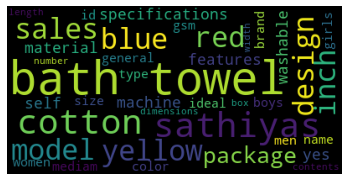

In [60]:
# Paramètre
p_id = 1
content = data.loc[p_id,'description_clean']

prec, tokens_nb = ' ', 0
for char in content:
  tokens_nb += int(prec == ' ' and char != ' ')
  prec = char

process_step = 'Texte original'
print(process_step,'  Nombre de tokens:',tokens_nb)
print(len(process_step)*'-')
print(content)

wordcloud(content)

$\color{orange}{\text{4- Tokenize}}$


Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.


1.   Character tokens: s-m-a-r-t-e-r
2.   Subword tokens: smart-er
3.   Word tokenization:  Never-give-up

https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/

https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/

In [61]:
def tokenization(text):
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  tokens=tokenizer.tokenize(text)
  return tokens

In [62]:
# Tokenizing  texts.
from nltk.tokenize import word_tokenize
nltk.download('punkt')

data['description_tokenized'] = data["description_clean"].apply(lambda x: tokenization(x))
data['name_tokenized'] = data["name_clean"].apply(lambda x: tokenization(x))
display(data.sample(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized
831,95b0779b1a04ab70d62c72b53090c4b3,95b0779b1a04ab70d62c72b53090c4b3.jpg,Orico USB 3.0 Hub with Card Reader H3TS-U3-BK ...,Buy Orico USB 3.0 Hub with Card Reader H3TS-U3...,Computers,2,LaptopAccessories,buy orico usb hub with card reader usb u...,orico usb hub with card reader usb usb hub,"[buy, orico, usb, hub, with, card, reader, usb...","[orico, usb, hub, with, card, reader, usb, usb..."
853,146b0d570d5ab4e27629d48533b7680d,146b0d570d5ab4e27629d48533b7680d.jpg,RRP Lamp For Computer Keyboard Tslplt02 USB Le...,RRP Lamp For Computer Keyboard Tslplt02 USB Le...,Computers,2,LaptopAccessories,rrp lamp for computer keyboard usb led ligh...,rrp lamp for computer keyboard usb led light,"[rrp, lamp, for, computer, keyboard, usb, led,...","[rrp, lamp, for, computer, keyboard, usb, led,..."


In [63]:
#test
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)
text_tokenized=data['description_tokenized'][idex]
print('#text tokenized#  :',text_tokenized)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : specifications of upside down sleeveless applique baby girls baby boys jacket general details ideal for baby girls baby boys pattern applique jacket details fabric poly cotton reversible no hooded no closure buttons sleeve sleeveless lining cotton fabric care do not wash with other garments hand wash with mild detergent do not tumble dry dry in shade additional details style code light pink smiley face jacket other details sleeveless in the box    jacket
#text tokenized#  : ['specifications', 'o

In [64]:
size_f_Td=word_size(data,'description_tokenized')
print(size_f_Td)

5059


In [65]:
size_f_Tn=word_size(data,'name_tokenized')
print(size_f_Tn)

1884


Tokenisation   Nombre de tokens: 67
------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


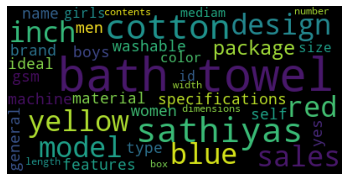

In [66]:
process_step = 'Tokenisation'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_tokenized']))
print(len(process_step)*'-')

content = data['description_tokenized'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [67]:
def clean_2(data,description_clean):
    
    data[description_clean] = data[description_clean].str.lower()

    data[description_clean] = data[description_clean].str.replace('\'','')
    data[description_clean] = data[description_clean].str.replace('\`','')    
    data[description_clean] = data[description_clean].str.replace('\"','')
    data[description_clean] = data[description_clean].str.replace('[','')
    data[description_clean] = data[description_clean].str.replace(']','')    
    data[description_clean] = data[description_clean].str.replace('(','')
    data[description_clean] = data[description_clean].str.replace(')','')
    data[description_clean] = data[description_clean].str.replace('{','')
    data[description_clean] = data[description_clean].str.replace('}','')

    data[description_clean] = data[description_clean].str.replace('@',' ')
    data[description_clean] = data[description_clean].str.replace('?',' ')
    data[description_clean] = data[description_clean].str.replace('!',' ')

    data[description_clean] = data[description_clean].str.replace(';',' ')
    data[description_clean] = data[description_clean].str.replace(',',' ')
    data[description_clean] = data[description_clean].str.replace('.',' ')    
    data[description_clean] = data[description_clean].str.replace(':',' ')

    data[description_clean] = data[description_clean].str.replace('&',' ')
    data[description_clean] = data[description_clean].str.replace('-',' ')
    data[description_clean] = data[description_clean].str.replace('/',' ')
    data[description_clean] = data[description_clean].str.replace('_',' ')
    data[description_clean] = data[description_clean].str.replace('±',' ')
    data[description_clean] = data[description_clean].str.replace('*',' ')
    data[description_clean] = data[description_clean].str.replace('%',' ')

    data[description_clean] = data[description_clean].str.replace('0',' ')
    data[description_clean] = data[description_clean].str.replace('1',' ')
    data[description_clean] = data[description_clean].str.replace('2',' ')
    data[description_clean] = data[description_clean].str.replace('3',' ')
    data[description_clean] = data[description_clean].str.replace('4',' ')
    data[description_clean] = data[description_clean].str.replace('5',' ')
    data[description_clean] = data[description_clean].str.replace('6',' ')
    data[description_clean] = data[description_clean].str.replace('7',' ')
    data[description_clean] = data[description_clean].str.replace('8',' ')
    data[description_clean] = data[description_clean].str.replace('9',' ') 
    
    data[description_clean] = data[description_clean].str.replace('aa',' ')
    data[description_clean] = data[description_clean].str.replace('aaa',' ')

    data[description_clean] = data[description_clean].str.replace('jumpsuit\r\n',' jumpsuit ')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\thigh',' thigh ')
    data[description_clean] = data[description_clean].str.replace('quality\xa0aluminum','quality aluminum')    
    data[description_clean] = data[description_clean].str.replace('boys\r\n','boys')
    data[description_clean] = data[description_clean].str.replace('abstrcts','abstract')
    data[description_clean] = data[description_clean].str.replace('asvtwl','')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\t',' ') 

    data[description_clean] = data[description_clean].str.replace('   ',' ') 
    data[description_clean] = data[description_clean].str.replace('  ',' ')    
 
    data[description_clean] = data[description_clean].astype('str')

In [68]:
normalization_ = 1
if normalization_ == 1:
    # On normalise les valeurs de la variable temporaire 'content_clean'
    clean_2(data,'description_clean')

In [69]:
tokens_list = []

# Tokenisation avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):
    # On tokenise les valeurs de la variale temporaire 'description_clean_1'
    # et on stocke les résultats dans une liste
    tokens_list.append(tokenizer.tokenize(data.loc[i,'description_clean']))
    
# On stocke les tokens dans une nouvelle variable 'content_tok_2'
data['description_clean_tok_2'] = tokens_list
# On supprime la variable temporaire 'content_clean'
#del data['description_clean_1']

data.head(2)

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi..."
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t..."


In [70]:
size_filtre4=word_size(data,'description_clean_tok_2')
print(size_filtre4)

5053


Tokenisation2   Nombre de tokens: 67
-------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


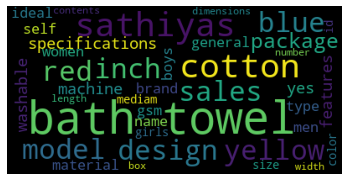

In [71]:
process_step = 'Tokenisation2'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_clean_tok_2']))
print(len(process_step)*'-')

content = data['description_clean_tok_2'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{5- Stop words}}$

In [72]:
stopword=nltk.corpus.stopwords.words('english')

In [73]:
def remove_sw(text):
  text=[word for word in text if word not in stopword]
  return text

In [74]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords


data['description_stopword'] = data['description_tokenized'].apply(lambda x: remove_sw(x))
data['name_stopword'] = data['name_tokenized'].apply(lambda x: remove_sw(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stopword'][idex]
print('#text without stopwords#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [76]:
size_filtre4=word_size(data,'description_stopword')
print(size_filtre4)

4945


In [77]:
size_filtre4=word_size(data,'name_stopword')
print(size_filtre4)

1841


stopword   Nombre de stop word: 61
--------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


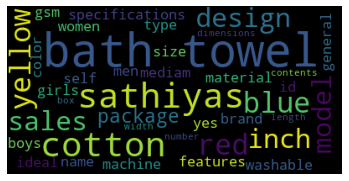

In [78]:
process_step = 'stopword'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_stopword']))
print(len(process_step)*'-')

content = data['description_stopword'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- 2nd stop words}}$

Deleting the words which has just one letter

In [79]:
def rem_short_words(words_list, char_len = 2):
    word_len = [len(i) for i in words_list]
    index_keep = np.array(word_len) > char_len
    words_list_red = np.array(words_list)[index_keep]
    return(list(words_list_red))

In [80]:
from nltk.corpus import stopwords
stop_words_0 = stopwords.words('english')
print('Nombre de stop words (base nltk):',len(stop_words_0))

Nombre de stop words (base nltk): 179


In [81]:
data['description_stw']=data['description_stopword'].apply(rem_short_words)
data['name_stw']=data['name_stopword'].apply(rem_short_words)

In [82]:
word_size(data,'description_stw')

4867

In [83]:
word_size(data,'name_stw')

1793

In [152]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stw'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

2nd stopword   Nombre de stw: 60
------------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


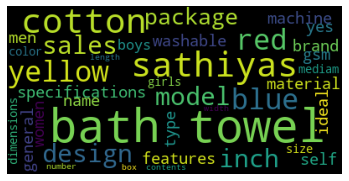

In [85]:
process_step = '2nd stopword'
print(process_step,'  Nombre de stw:',len(data.loc[p_id,'description_stw']))
print(len(process_step)*'-')

content = data['description_stw'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [153]:
data['description_stw']

0       [key, features, elegance, polyester, multicolo...
1       [specifications, sathiyas, cotton, bath, towel...
2       [key, features, eurospa, cotton, terry, face, ...
3       [key, features, santosh, royal, fashion, cotto...
4       [key, features, jaipur, print, cotton, floral,...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: description_stw, Length: 1050, dtype: object

$\color{orange}{\text{6- POS tagging}}$

is a task of labelling each word in a sentence with its appropriate ***part of speech***. We already know that parts of speech include nouns, verb, adverbs, adjectives, pronouns, conjunction and their sub-categories.

In [151]:
from nltk import pos_tag
from nltk import RegexpParser
text ="learn php from guru99 and make study easy".split()

print("After Split:",text)
tokens_tag = pos_tag(text)

print("After Token:",tokens_tag)
patterns= """mychunk:{<NN.?>*<VBD.?>*<JJ.?>*<CC>?}"""

chunker = RegexpParser(patterns)
print("After Regex:",chunker)
output = chunker.parse(tokens_tag)
print("After Chunking",output)

After Split: ['learn', 'php', 'from', 'guru99', 'and', 'make', 'study', 'easy']
After Token: [('learn', 'JJ'), ('php', 'NN'), ('from', 'IN'), ('guru99', 'NN'), ('and', 'CC'), ('make', 'VB'), ('study', 'NN'), ('easy', 'JJ')]
After Regex: chunk.RegexpParser with 1 stages:
RegexpChunkParser with 1 rules:
       <ChunkRule: '<NN.?>*<VBD.?>*<JJ.?>*<CC>?'>
After Chunking (S
  (mychunk learn/JJ)
  (mychunk php/NN)
  from/IN
  (mychunk guru99/NN and/CC)
  make/VB
  (mychunk study/NN easy/JJ))


In [89]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk import RegexpParser
nltk.sent_tokenize
data['description_pos_tags'] = data['description_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data['name_pos_tags'] = data['name_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data.head(2)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2,description_stopword,name_stopword,description_stw,name_stw,description_pos_tags,name_pos_tags
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...","[NN, NN, NN, JJ, NN, NN, NN]"
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...","[JJ, NN, NN, NN]"


In [145]:
word_list=[]
for i in range(len(data['description_stw'])):
    word_list.append([])
    
for i in range(len(data['description_stw'])): 
    for word in data['description_stw'][i]:
        if word[0:].isalpha():
            word_list[i].append(word[0:]) 


AttributeError: ignored

In [149]:
s = word_list
tagged_sent = pos_tag(s)
print(tagged_sent)

AttributeError: ignored

In [121]:
from nltk import word_tokenize, pos_tag, pos_tag_sents

texts = data['description_stw'].tolist()
tagged_texts = pos_tag_sents(map(word_tokenize, texts))
tagged_texts

TypeError: ignored

In [ ]:
data['POS'] = tagged_texts

In [150]:
words = [word for key in word_list for word in key.split()]  
tags = [tag for value in value_list for tag in value.split()]  

AttributeError: ignored

In [103]:
def pos_tag_(s):
  tagged_sent = pos_tag(s)
  nltk_tokens = nltk.word_tokenize(s)
  corpus  = [word for word, pos in nltk.pos_tag(nltk_tokens) if not  pos in tagged_sent] # Select all words that don't have the undesired tags
  return   ' '.join(map(str, corpus))

In [104]:
from nltk.tokenize import wordpunct_tokenize
data['description_pt']=data['description_stw'].apply(lambda x: pos_tag_(x))

TypeError: ignored

In [585]:
text= data['description_pos_tags']
print("After Split:",text)
tokens_tag = pos_tag(text)

print("After Token:",tokens_tag)
patterns= """mychunk:{<NN.?>*<VBD.?>*<JJ.?>*<CC>?}"""

chunker = RegexpParser(patterns)
print("After Regex:",chunker)
output = chunker.parse(tokens_tag)
print("After Chunking",output)

After Split: 0       [JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...
1       [NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...
2       [JJ, NNS, VBP, NN, NN, NN, NN, VBN, NN, JJ, NN...
3       [JJ, NNS, VBP, JJ, NN, NN, VBD, VBG, VBN, JJ, ...
4       [JJ, NNS, VBP, JJ, NN, JJ, NN, VBN, JJ, NN, NN...
                              ...                        
1045    [NNS, VBP, JJ, JJ, NN, JJ, NN, NN, NN, JJ, NN,...
1046    [JJ, JJ, NN, NN, NN, NN, NN, NN, NN, JJ, NN, N...
1047    [VB, JJ, JJ, JJ, VBN, NN, NNS, VBN, NN, NN, JJ...
1048    [VB, JJ, NN, NN, NN, NN, NN, JJ, NN, NN, NN, N...
1049    [VB, JJ, JJ, NN, NN, NN, JJ, JJ, NN, NN, JJS, ...
Name: description_pos_tags, Length: 1050, dtype: object


AttributeError: ignored

In [572]:
patterns= """mychunk:{<NN.?>*<VBD.?>*<JJ.?>*<CC>?}"""
chunker = RegexpParser(patterns)
print("After Regex:",chunker)
chunked = []
cp = nltk.RegexpParser(patterns)
output= data['description_pos_tags']

for s in data['description_pos_tags']:
  chunked.append(cp.parse(s))
data['description_chunk'] = data['description_pos_tags'].apply(lambda x:[t for w, t in chunker.parse(x)])
data.head(2)

After Regex: chunk.RegexpParser with 1 stages:
RegexpChunkParser with 1 rules:
       <ChunkRule: '<NN.?>*<VBD.?>*<JJ.?>*<CC>?'>


ValueError: ignored

In [96]:
data['description_pos_tags_sentence'] = data['description_pos_tags'].apply(lambda x: ' '.join(x))
data['name_pos_tags_sentence'] = data['name_pos_tags'].apply(lambda x: ' '.join(x))
data.head(2)

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2,description_stopword,name_stopword,description_stw,name_stw,description_pos_tags,name_pos_tags,description_pos_tags_sentence,name_pos_tags_sentence
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...","[NN, NN, NN, JJ, NN, NN, NN]",JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...","[JJ, NN, NN, NN]",NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN


In [412]:
#removes adverbe
tag_list = ['NNS IN JJ NN CC JJ JJ NNS VBP DT NN IN DT NNS .',
 ' IN DT NN , JJ NN MD VB VBN TO VB DT JJ NN NNS WDT VB DT JJ JJ JJ NNS IN DT NN NN .', 
 ' JJ NNS VBP JJ .'] # List of Adjective's,Verbe's tag from nltk package

def remove_adv(text):
  nltk_tokens = nltk.word_tokenize(text)
  corpus  = [word for word, pos in nltk.pos_tag(nltk_tokens) if not  pos in tag_list] # Select all words that don't have the undesired tags
  return   ' '.join(map(str, corpus))

In [413]:
data['description_adv']=data['description_pos_tags_sentence'].apply(lambda x: remove_adv(x))
data["name_adv"] = data["name_pos_tags_sentence"].apply(lambda x: remove_adv(x))

In [ ]:

#test
text=data.description_pos_tags_sentence[idex]
print('#text originale#:',text)
text_modifier=data['description_adv'][idex]
print('#text modifié#  :',text_modifier)

#text originale#: JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN
#text modifié#  : JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN


In [ ]:
word_size(data,'description_adv')

27

In [ ]:
word_size(data,'name_adv')

25

In [ ]:
data['name_adv'].nunique()

591

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


list_of_verbs = []
for i in range(len(description_pos_tags)):
if description_pos_tags[i][18].startswith('V') :
list_of_verbs.append(description_pos_tags[i][18])

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(list_of_verbs)

IndentationError: ignored

### **Reducing the words**
* Stemming
* Lemmatization

$\color{orange}{\text{6- Lemmatization}}$

The real difference between stemming and lemmatization is that Stemming reduces word-forms to (pseudo)stems which might be meaningful or meaningless, whereas lemmatization reduces the word-forms to linguistically valid meaning.

In [414]:
import nltk
nltk.download('wordnet')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [415]:
data['description_lemma']=data['description_stw'].apply(lambda x : lemmatize_text(x))
data['name_lemma']=data['name_stw'].apply(lambda x : lemmatize_text(x))

In [416]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_lemma'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [417]:
word_size(data,'description_lemma')

4460

In [418]:
word_size(data,'name_lemma')

1746

description_lemma   Nombre de stop word: 60
-----------------
specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men woman boy girl model color red yellow blue size mediam dimension length inch width inch box number content sale package sale package bath towel


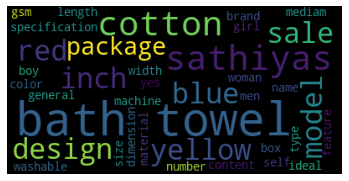

In [419]:
process_step = 'description_lemma'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_lemma']))
print(len(process_step)*'-')

content = data['description_lemma'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{7- Stemming}}$

In [420]:
data.head(2)

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2,description_stopword,name_stopword,description_stw,name_stw,description_pos_tags,name_pos_tags,description_pos_tags_sentence,name_pos_tags_sentence,description_adv,name_adv,description_lemma,name_lemma
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...","[NN, NN, NN, JJ, NN, NN, NN]",JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,"[key, feature, elegance, polyester, multicolor...","[elegance, polyester, multicolor, abstract, ey..."
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...","[JJ, NN, NN, NN]",NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,"[specification, sathiyas, cotton, bath, towel,...","[sathiyas, cotton, bath, towel]"


In [421]:
from nltk.stem.snowball import EnglishStemmer
stemm=EnglishStemmer()

def stem_word(text):
  stem_text=[stemm.stem(word)for word in text] 
  return stem_text


In [422]:
data['description_stem'] = data['description_lemma'].apply(lambda x: stem_word(x)) 
data['name_stem'] = data['name_lemma'].apply(lambda x: stem_word(x))

In [423]:
#test
text=data.description_lemma[idex]
print('#text originale#:',text)
text_modifier=data['description_stem'][idex]
print('#text modifié#  :',text_modifier)

#text originale#: ['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'soft

In [424]:
word_size(data,'description_stem')

3877

supprimer les mots courts

In [425]:
data["description_short"] = data["description_stem"].apply(lambda x: rem_short_words(x))
data["name_short"] = data["name_stem"].apply(lambda x: rem_short_words(x))

In [426]:
word_size(data,'description_short')

3863

In [427]:
word_size(data,'name_short')

1700

stemming   Nombre de tonek: 60
--------
specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl yes materi cotton design self design general brand sathiya type bath towel gsm model name sathiya cotton bath towel ideal men woman boy girl model color red yellow blue size mediam dimens length inch width inch box number content sale packag sale packag bath towel


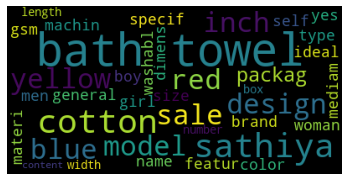

In [428]:
process_step = 'stemming'
print(process_step,'  Nombre de tonek:',len(data.loc[p_id,'description_short']))
print(len(process_step)*'-')

content = data['description_short'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

### **Frequency calculation**

Term frequency answers the question of, how many times does this word appear in this document, how important is this word to this specific document.

The re. compile() method:

With this method we can combine a regular expression pattern into pattern objects, which can be used for pattern matching. It also helps to search a pattern again without rewriting it

In [429]:
# http://pymotw.com/2/re/

import re
#import the regular expressions

corpus=data['description_stem']
words_dico=dict()

expr =re.compile("\W+",re.U) #  method is used to compile a regular expression pattern provided as a string into a regex pattern object (re.Pattern)
for text in corpus:           # re.U. Interprets letters according to the Unicode character set. This flag affects the behavior of \w, \W, \b, \B. 6.
  text = str(text)
  text = expr.split(text)
  for word in set(text): 
    if word not in words_dico:
      words_dico[word]=1
    else: 
          words_dico[word]=words_dico[word]+1



In [430]:
len(words_dico)

3877

**Frequency exploration**

In [431]:
df_word_freq=pd.DataFrame({'words':words_dico.keys(),'Frequency':words_dico.values()})

In [432]:
df=df_word_freq.sort_values(ascending=False,by='Frequency')
df.head()

,words,Frequency
0,,1050
120,product,667
203,free,594
197,buy,576
212,deliveri,566


**Droping all the space**

In [433]:
df_word_freq.drop([0],inplace=True, axis=0)

In [434]:
df_word_freq.sort_values(ascending=False,by='Frequency').head()

,words,Frequency
120,product,667
203,free,594
197,buy,576
212,deliveri,566
199,ship,565


Text(0.5, 1.0, 'Frequency of words')

<Figure size 1440x720 with 0 Axes>

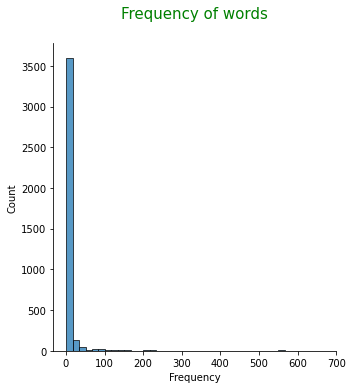

In [435]:
plt.figure(figsize=(20,10))
sns.displot(data=df_word_freq,bins=40, x="Frequency");
plt.title('Frequency of words', fontsize = 15, pad = 25, color='green')

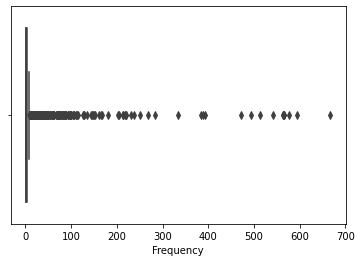

In [436]:
sns.boxplot(data=df_word_freq,x='Frequency');

In [437]:
df_word_freq['Frequency'].describe()

count    3876.000000
mean        8.394479
std        37.071738
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       667.000000
Name: Frequency, dtype: float64

In [438]:
sorted_freq=df_word_freq.sort_values(by='Frequency',ascending=False)

In [439]:
df1=sorted_freq[0:40]

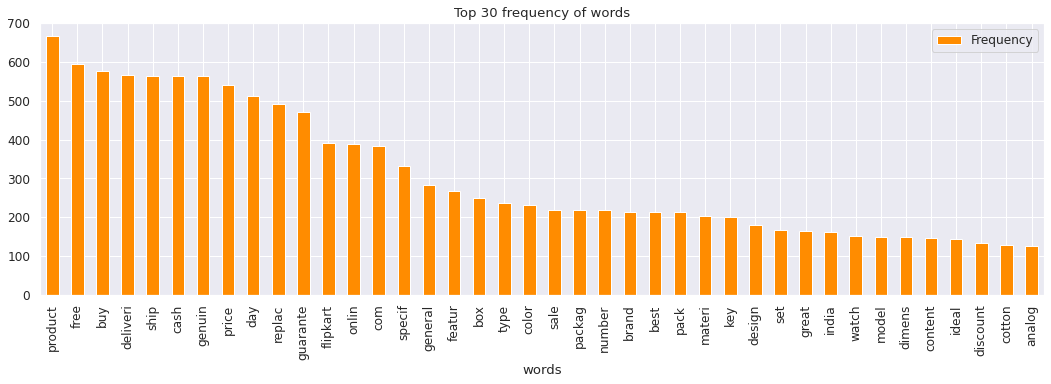

In [440]:

sns.set(font_scale=1.1)
df1.plot(kind='bar',x='words',y='Frequency',title='Top 30 frequency of words',figsize=(18,5) ,color="darkorange")

In [441]:
df2=sorted_freq[-41:-1]

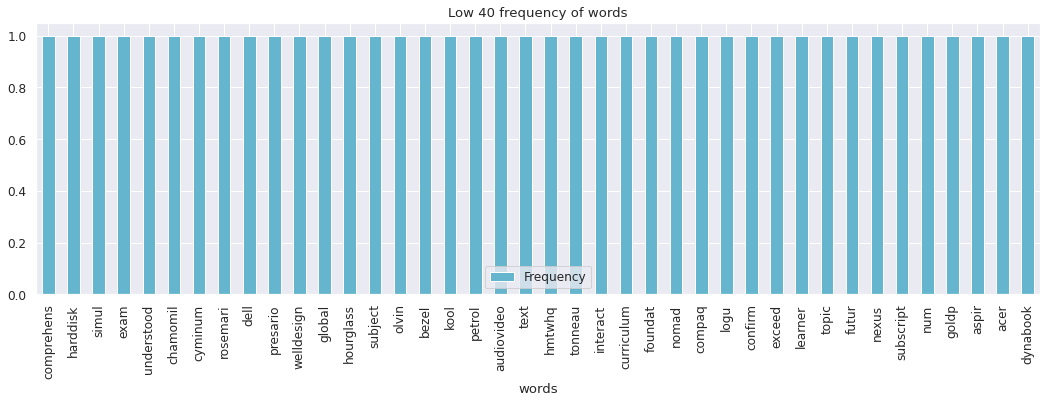

In [442]:
df2.plot(kind='bar',x='words',y='Frequency', color="c",figsize=(18,5),title='Low 40 frequency of words')

In [443]:
len(sorted_freq)

3876

**Filtering dataset**

In [444]:
data.head(2)

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2,description_stopword,name_stopword,description_stw,name_stw,description_pos_tags,name_pos_tags,description_pos_tags_sentence,name_pos_tags_sentence,description_adv,name_adv,description_lemma,name_lemma,description_stem,name_stem,description_short,name_short
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...","[NN, NN, NN, JJ, NN, NN, NN]",JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,"[key, feature, elegance, polyester, multicolor...","[elegance, polyester, multicolor, abstract, ey...","[key, featur, eleg, polyest, multicolor, abstr...","[eleg, polyest, multicolor, abstract, eyelet, ...","[key, featur, eleg, polyest, multicolor, abstr...","[eleg, polyest, multicolor, abstract, eyelet, ..."
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...","[JJ, NN, NN, NN]",NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,"[specification, sathiyas, cotton, bath, towel,...","[sathiyas, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, t...","[sathiya, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, t...","[sathiya, cotton, bath, towel]"


In [445]:
print(len(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1]),"words are repeated once")

2012 words are repeated once


In [446]:
rem_list = list(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1])
df_word_freq['words'][rem_list].values

array(['joyous', 'romant', 'modernist', ..., 'sweep', 'polyvinyl', 'film'],
      dtype=object)

In [447]:
data['final'] = data['description_short']
data.head(2)

,uniq_id,image,product_name,description,category,label_category,category_1,description_clean,name_clean,description_tokenized,name_tokenized,description_clean_tok_2,description_stopword,name_stopword,description_stw,name_stw,description_pos_tags,name_pos_tags,description_pos_tags_sentence,name_pos_tags_sentence,description_adv,name_adv,description_lemma,name_lemma,description_stem,name_stem,description_short,name_short,final
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home,5,Curtains&Accessories,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,"[key, features, of, elegance, polyester, multi...","[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, polyester, multicolor, abstract, ey...","[JJ, NNS, VBP, NN, NN, JJ, NN, NN, VBP, JJ, NN...","[NN, NN, NN, JJ, NN, NN, NN]",JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN J...,NN NN NN JJ NN NN NN,"[key, feature, elegance, polyester, multicolor...","[elegance, polyester, multicolor, abstract, ey...","[key, featur, eleg, polyest, multicolor, abstr...","[eleg, polyest, multicolor, abstract, eyelet, ...","[key, featur, eleg, polyest, multicolor, abstr...","[eleg, polyest, multicolor, abstract, eyelet, ...","[key, featur, eleg, polyest, multicolor, abstr..."
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby,0,BabyBath&Skin,specifications of sathiyas cotton bath towel b...,sathiyas cotton bath towel,"[specifications, of, sathiyas, cotton, bath, t...","[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t...","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel...","[sathiyas, cotton, bath, towel]","[NNS, VBP, NN, NN, NN, NN, NN, VBD, JJ, JJ, NN...","[JJ, NN, NN, NN]",NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,NNS VBP NN NN NN NN NN VBD JJ JJ NN NN NNS NN ...,JJ NN NN NN,"[specification, sathiyas, cotton, bath, towel,...","[sathiyas, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, t...","[sathiya, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, t...","[sathiya, cotton, bath, towel]","[specif, sathiya, cotton, bath, towel, bath, t..."


## **Bag of words**

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.

In [448]:
data.keys()

Index(['uniq_id', 'image', 'product_name', 'description', 'category',
       'label_category', 'category_1', 'description_clean', 'name_clean',
       'description_tokenized', 'name_tokenized', 'description_clean_tok_2',
       'description_stopword', 'name_stopword', 'description_stw', 'name_stw',
       'description_pos_tags', 'name_pos_tags',
       'description_pos_tags_sentence', 'name_pos_tags_sentence',
       'description_adv', 'name_adv', 'description_lemma', 'name_lemma',
       'description_stem', 'name_stem', 'description_short', 'name_short',
       'final'],
      dtype='object')

In [449]:
data['description_short_']= data['description_short'].apply(lambda x: ' '.join(x))
data['name_short_']= data['name_short'].apply(lambda x: ' '.join(x))

In [450]:
#vectorize
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer_1=CountVectorizer( min_df = 0.01, stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=(1,1))
tf_matrix_1 = tf_vectorizer_1.fit_transform(data['description_short_'])

In [451]:
features_names=tf_vectorizer_1.get_feature_names()
#dense=X.todense()
#denselist=dense.tolist()
#word_fre_vect=pd.DataFrame(denselist,columns=features_names)
word_fre_vect_uni=pd.DataFrame(tf_matrix_1.toarray(),columns=tf_vectorizer_1.get_feature_names())
word_fre_vect_uni.head(3)

,abstract,accessori,actual,adapt,add,addit,ador,afford,age,aluminium,analog,antiqu,appeal,appl,appli,area,aroma,art,artist,assur,attract,authent,avail,babi,bag,base,bath,batteri,beauti,bed,bedroom,bedsheet,best,black,blanket,bleach,blue,bodi,bottl,box,boy,brand,brass,break,bring,broadcast,brown,buckl,bulb,button,buy,cabl,capac,care,carri,case,cash,casual,catchi,cell,ceram,certif,charger,check,checker,cheer,clasp,classic,clean,clear,closur,cloth,code,coffe,coffeetea,cold,collect,color,colour,com,combin,combo,come,comfort,compat,complet,consumpt,contain,contemporari,content,cor,cotton,cover,craft,cream,creation,cupcak,curtain,cushion,custom,cute,damag,dark,day,decor,defect,deliveri,depth,design,deterg,devic,dial,diamet,differ,digit,dimens,disclaim,discount,display,distinct,door,doubl,dress,dri,durabl,eas,easi,easili,eleg,enhanc,enjoy,ensur,essenti,everi,exclus,express,extern,eye,eyelet,fabric,face,factori,fantast,fashion,featur,feel,fine,finish,fit,flat,flexibl,flipkart,floral,forget,frame,free,freedom,freezer,fresh,friend,fruit,general,gentl,genuin,geometr,gift,girl,glass,gold,golden,good,grade,graphic,great,green,grey,group,guarante,guest,hair,half,hand,handcraft,handicraft,handl,handmad,hang,happi,hard,head,height,help,high,highest,holiday,home,hook,hous,huge,ideal,imag,import,inch,includ,india,indic,ink,instal,interior,iron,item,kadhai,key,kid,kind,king,kit,kitchen,know,label,lamin,lapguard,laptop,larg,laugh,layer,leav,led,length,life,light,like,limit,line,linen,littl,live,long,look,love,lowest,machin,magnet,make,manufactur,massag,materi,maximum,mean,medium,men,messag,metal,microwav,midikne,mini,model,month,morn,mous,mug,multi,multicolor,natur,necessari,neck,need,new,night,normal,note,number,occas,offer,offic,oil,onlin,orang,order,organ,origin,pack,packag,pad,paint,paper,pari,parti,partywed,pass,pattern,pavilion,perfect,perform,perman,pick,pictur,piec,pillow,pin,pink,place,plain,plastic,play,pleas,polyest,porcelain,port,portabl,power,premium,present,price,print,printland,prithish,product,protect,provid,pure,qualiti,quantiti,quilt,quot,rajasthan,rang,rate,rectangl,red,reflect,regular,relax,remov,repair,replac,requir,resist,rest,right,rockmantra,roh,room,round,router,safe,safeti,sale,say,scratch,screen,select,self,send,seri,serv,servic,set,shade,shape,share,sheet,ship,shirt,shop,short,showpiec,silver,similar,singl,sip,size,skin,sleev,sleeveless,slight,small,smart,smile,smooth,soap,soft,solid,sonata,sourc,special,specif,spread,stainless,start,statu,stay,steel,sticker,stone,strap,stripe,style,stylish,suit,suitabl,suitablefor,summari,sure,surfac,tabl,talk,teacoffe,thrill,time,togeth,toodishwash,touch,towel,tradit,trait,tube,tumbl,type,uniqu,usb,use,vari,video,vinyl,vitamin,voltag,wall,wardrob,warm,warranti,wash,washabl,watch,water,waterproof,way,wear,weight,white,wide,width,wireless,woman,wood,wooden,work,world,wrap,year,yellow,yes
0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,6,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,2,0,2,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [452]:
word_fre_vect_uni.shape

(1050, 452)

In [453]:
df=pd.DataFrame({'Word frequancy': word_fre_vect_uni.max().sort_values(ascending=False).index,'Total':word_fre_vect_uni.max().sort_values(ascending=False).values})

In [454]:
df

,Word frequancy,Total
0,product,21
1,laptop,21
2,blanket,19
3,towel,18
4,skin,18
...,...,...
447,cash,1
448,genuin,1
449,suitablefor,1
450,summari,1


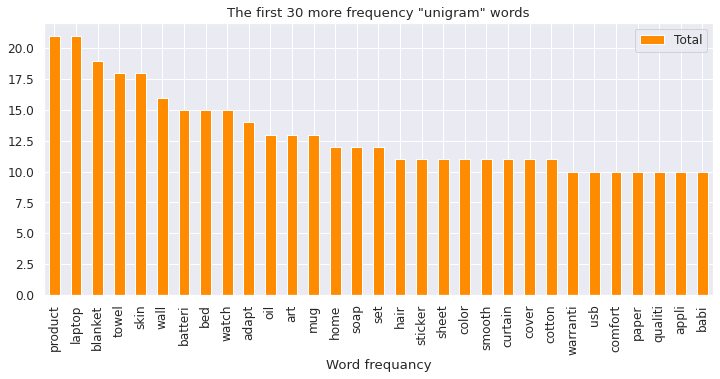

In [455]:

df1=df.loc[0:30,['Word frequancy','Total']]

df1.plot(kind='bar',x='Word frequancy',y='Total', color="darkorange",title='The first 30 more frequency "unigram" words',figsize=(12,5))


In [456]:
tf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tf_matrix_2 = tf_vectorizer_2.fit_transform(data['description_short_'])

In [457]:
features_names=tf_vectorizer_2.get_feature_names()
word_fre_vect_bi=pd.DataFrame(tf_matrix_2.toarray(),columns=tf_vectorizer_2.get_feature_names())

In [458]:
df_v2=pd.DataFrame({'Word frequancy': word_fre_vect_bi.max().sort_values(ascending=False).index,'Total':word_fre_vect_bi.max().sort_values(ascending=False).values})

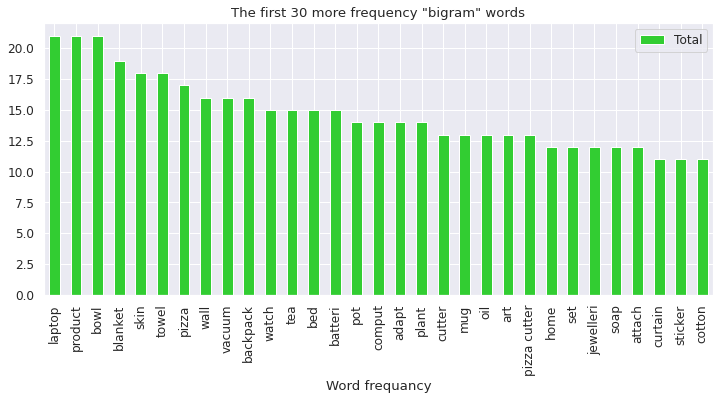

In [459]:
df2=df_v2.loc[0:30,['Word frequancy','Total']]

df2.plot(kind='bar',x='Word frequancy',y='Total', color="limegreen",title='The first 30 more frequency "bigram" words',figsize=(12,5))

### **TF IDF**
Term frequency-inverse document frequency

Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.
tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification. One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [460]:
# unigrams
tfidf_vectorizer_1 = TfidfVectorizer( min_df = 0.01, stop_words = 'english', analyzer="word", token_pattern=r'\w+')
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(data['description_short_'])


In [461]:
features_names=tfidf_vectorizer_1.get_feature_names()
dense=tfidf_matrix_1.todense()
denselist=dense.tolist()
words_freq_1=pd.DataFrame(denselist,columns=features_names)
words_freq_1.head(3)

,abstract,accessori,actual,adapt,add,addit,ador,afford,age,aluminium,analog,antiqu,appeal,appl,appli,area,aroma,art,artist,assur,attract,authent,avail,babi,bag,base,bath,batteri,beauti,bed,bedroom,bedsheet,best,black,blanket,bleach,blue,bodi,bottl,box,boy,brand,brass,break,bring,broadcast,brown,buckl,bulb,button,buy,cabl,capac,care,carri,case,cash,casual,catchi,cell,ceram,certif,charger,check,checker,cheer,clasp,classic,clean,clear,closur,cloth,code,coffe,coffeetea,cold,collect,color,colour,com,combin,combo,come,comfort,compat,complet,consumpt,contain,contemporari,content,cor,cotton,cover,craft,cream,creation,cupcak,curtain,cushion,custom,cute,damag,dark,day,decor,defect,deliveri,depth,design,deterg,devic,dial,diamet,differ,digit,dimens,disclaim,discount,display,distinct,door,doubl,dress,dri,durabl,eas,easi,easili,eleg,enhanc,enjoy,ensur,essenti,everi,exclus,express,extern,eye,eyelet,fabric,face,factori,fantast,fashion,featur,feel,fine,finish,fit,flat,flexibl,flipkart,floral,forget,frame,free,freedom,freezer,fresh,friend,fruit,general,gentl,genuin,geometr,gift,girl,glass,gold,golden,good,grade,graphic,great,green,grey,group,guarante,guest,hair,half,hand,handcraft,handicraft,handl,handmad,hang,happi,hard,head,height,help,high,highest,holiday,home,hook,hous,huge,ideal,imag,import,inch,includ,india,indic,ink,instal,interior,iron,item,kadhai,key,kid,kind,king,kit,kitchen,know,label,lamin,lapguard,laptop,larg,laugh,layer,leav,led,length,life,light,like,limit,line,linen,littl,live,long,look,love,lowest,machin,magnet,make,manufactur,massag,materi,maximum,mean,medium,men,messag,metal,microwav,midikne,mini,model,month,morn,mous,mug,multi,multicolor,natur,necessari,neck,need,new,night,normal,note,number,occas,offer,offic,oil,onlin,orang,order,organ,origin,pack,packag,pad,paint,paper,pari,parti,partywed,pass,pattern,pavilion,perfect,perform,perman,pick,pictur,piec,pillow,pin,pink,place,plain,plastic,play,pleas,polyest,porcelain,port,portabl,power,premium,present,price,print,printland,prithish,product,protect,provid,pure,qualiti,quantiti,quilt,quot,rajasthan,rang,rate,rectangl,red,reflect,regular,relax,remov,repair,replac,requir,resist,rest,right,rockmantra,roh,room,round,router,safe,safeti,sale,say,scratch,screen,select,self,send,seri,serv,servic,set,shade,shape,share,sheet,ship,shirt,shop,short,showpiec,silver,similar,singl,sip,size,skin,sleev,sleeveless,slight,small,smart,smile,smooth,soap,soft,solid,sonata,sourc,special,specif,spread,stainless,start,statu,stay,steel,sticker,stone,strap,stripe,style,stylish,suit,suitabl,suitablefor,summari,sure,surfac,tabl,talk,teacoffe,thrill,time,togeth,toodishwash,touch,towel,tradit,trait,tube,tumbl,type,uniqu,usb,use,vari,video,vinyl,vitamin,voltag,wall,wardrob,warm,warranti,wash,washabl,watch,water,waterproof,way,wear,weight,white,wide,width,wireless,woman,wood,wooden,work,world,wrap,year,yellow,yes
0,0.193004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.043115,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.043115,0.0,0.028225,0.000000,0.030071,0.0,0.0,0.049915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.029136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062685,0.034490,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.622267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096215,0.0,0.0,0.0,0.0,0.0,0.0,0.034333,0.0,0.0,0.0,0.0,0.291369,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.30507,0.061824,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.346066,0.037144,0.000000,0.0,0.0,0.0,0.054932,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.04962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026794,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.054189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080647,0.0,0.044157,0.0,0.0,0.082837,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.063616,0.00000,0.0,0.0,0.030738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [462]:
words_freq_1.shape 

(1050, 452)

In [463]:
df=pd.DataFrame({'word_freq': words_freq_1.max().sort_values(ascending=False).index,'Total':words_freq_1.max().sort_values(ascending=False).values})

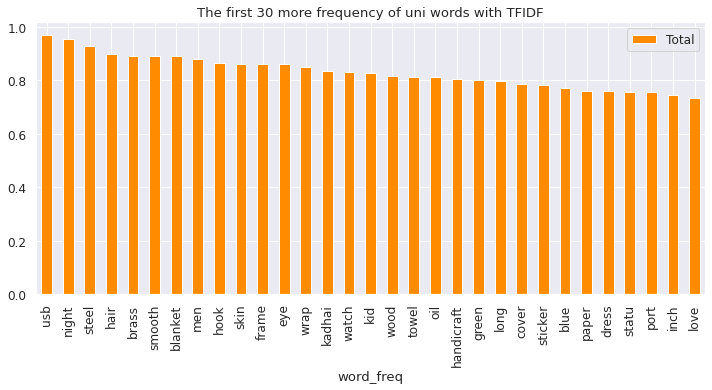

In [464]:
df1=df.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="darkorange",title='The first 30 more frequency of uni words with TFIDF',figsize=(12,5))

In [465]:
# unigram & bigrams
tfidf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(data['description_short_'])

In [466]:
features_names=tf_vectorizer_2.get_feature_names()
dense=tf_matrix_2.todense()
denselist=dense.tolist()
words_freq_2=pd.DataFrame(denselist,columns=features_names)
words_freq_2.head(3)

aapno  aapno rajasthan  abil  abl  abl light  abod  absorb  abstract  \
0      0                0     0    0          0     0       0         4   
1      0                0     0    0          0     0       0         0   
2      0                0     0    0          0     0       1         0   

   abstract art  abstract ceram  abstract cushion  abstract design  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   

   abstract doubl  abstract eyelet  abstract floral  abstract singl  accent  \
0               0                3                0               0       0   
1               0                0                0               0       0   
2               0                0                0               0       0   

   access  accessori  accessori batteri  accid  accident  accident damag  \
0       0          0                  0      0         0               0   
1       0          0                  0      0         0               0   
2       0          0                  0      0         0               0   

   accord  ach  across  across world  act  actual  actual product  adapt  \
0       0    0       0             0    0       0               0      0   
1       0    0       0             0    0       0               0      0   
2       0    0       0             0    0       0               0      0   

   adapt also  adapt charger  adapt come  adapt conform  adapt design  \
0           0              0           0              0             0   
1           0              0           0              0             0   
2           0              0           0              0             0   

   adapt equip  adapt general  adapt key  adapt laptop  adapt model  \
0            0              0          0             0            0   
1            0              0          0             0            0   
2            0              0          0             0            0   

   adapt output  adapt pin  adapt pleas  adapt power  adapt price  \
0             0          0            0            0            0   
1             0          0            0            0            0   
2             0          0            0            0            0   

   adapt voltag  adaptor  adaptor usb  add  add eleg  add kitchen  \
0             0        0            0    0         0            0   
1             0        0            0    0         0            0   
2             0        0            0    0         0            0   

   add perfect  add spunk  add touch  addit  addit detail  addit featur  \
0            0          0          0      0             0             0   
1            0          0          0      0             0             0   
2            0          0          0      0             0             0   

   addit kitchen  addit trait  adhes  adhes pvc  adhes sticker  adida  \
0              0            0      0          0              0      0   
1              0            0      0          0              0      0   
2              0            0      0          0              0      0   

   adida ice  adjust  adjust shoulder  admir  admir guest  ador  ador fantast  \
0          0       0                0      0            0     0             0   
1          0       0                0      0            0     0             0   
2          0       0                0      0            0     0             0   

   adorn  adsl  adsl modem  advic  advic inadvert  aero  aero care  affect  \
0      0     0           0      0               0     0          0       0   
1      0     0           0      0               0     0          0       0   
2      0     0           0      0               0     0          0       0   

   affect antiag  afford  afford art  afford mug  age  age group  aid  air  \
0              0       0           0           0    

In [467]:
words_freq_2.shape

(1050, 5651)

In [468]:
df_2=pd.DataFrame({'word_freq': words_freq_2.max().sort_values(ascending=False).index,'Total':words_freq_2.max().sort_values(ascending=False).values})


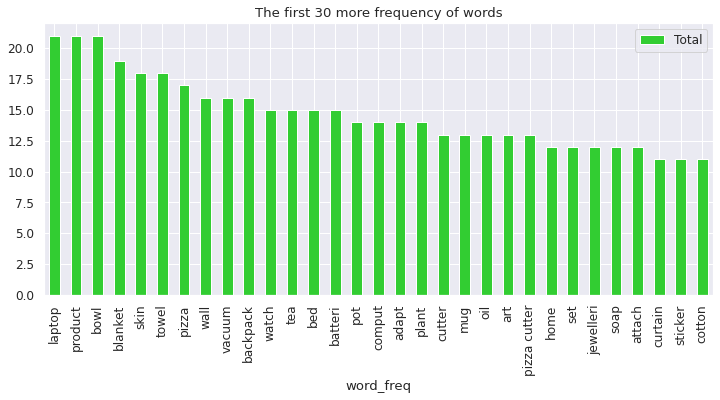

In [469]:
df1=df_2.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="limegreen",title='The first 30 more frequency of words',figsize=(12,5))

In [470]:
data['concat']=data['description_short_']+' '+data['name_short_']

In [471]:
#test
text=data.description[700]
print('#text originale#:',text)
text_modifier=data['description_short_'][700]
print('#text modifié#  :',text_modifier)

#text originale#: Specifications of Vgstore Rectangular Pack of 6 Table Placemat (Dark Blue, PVC) General Brand Vgstore Shape Rectangular Design Code blstri Material PVC Style Code strblue Color Dark Blue In the Box Number of Contents in Sales Package Pack of 6
#text modifié#  : specif vgstore rectangular pack tabl placemat dark blue pvc general brand vgstore shape rectangular design code blstri materi pvc style code strblue color dark blue box number content sale packag pack


In [472]:
#define vectorizer parameters
from sklearn.feature_extraction.text import CountVectorizer

def BOVW_TF(X,n_gram):
    tfidf_vectorizer = TfidfVectorizer( min_df = 0.01, max_df=0.7, stop_words = 'english', analyzer="word", token_pattern=r'\w+',  ngram_range=n_gram)
    tf_vectorizer= CountVectorizer( min_df = 0.01,  max_df=0.7,stop_words = 'english', analyzer="word", token_pattern=r'\w+', ngram_range=n_gram)
    # Generate matrix of word vectors
    # tf-idf (term frequency-inverse document frequency)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X)
    tfidf_words = tfidf_vectorizer.get_feature_names()

    # bag of words (term frequency)
    tf_matrix=tf_vectorizer.fit_transform(X)
    tf_words = tf_vectorizer.get_feature_names()

    return tfidf_matrix,tf_matrix

In [473]:
data['concat']=data['description_clean']+' '+data['name_clean']

tfidf_matrix_N,  tf_matrix_N = BOVW_TF(data['name_clean'].copy(),n_gram=(1,2))
tfidf_matrix_NF,  tf_matrix_NF = BOVW_TF(data['name_short_'].copy(),n_gram=(1,2))

tfidf_matrix_D,  tf_matrix_D = BOVW_TF(data['description_clean'].copy(),n_gram=(1,1))
tfidf_matrix_DF,  tf_matrix_DF = BOVW_TF(data['description_short_'].copy(),n_gram=(1,1))

#uni & bi
tfidf_matrix_D_b,  tf_matrix_D_b  =  BOVW_TF(data['description_clean'].copy(),n_gram=(1,2))
tfidf_matrix_DF_b,  tf_matrix_DF_b =  BOVW_TF(data['description_short_'].copy(),n_gram=(1,2))

In [474]:
# clean & unigram
print(tf_matrix_D.shape)  
print(tfidf_matrix_D.shape)

(1050, 476)
(1050, 476)


In [475]:
# final & unigram
print(tf_matrix_DF.shape)  
print(tfidf_matrix_DF.shape)

(1050, 452)
(1050, 452)


In [ ]:
# final & unigram & bigram
print(tf_matrix_DF_b.shape)  
print(tfidf_matrix_DF_b.shape)

(1050, 829)
(1050, 829)


In [ ]:
# clean & unigram & bigram
print(tf_matrix_D_b.shape)  
print(tfidf_matrix_D_b.shape)

(1050, 876)
(1050, 876)


### **Dimentional reduction**

In [476]:
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE

def plot_tsne_pca(matrix,title,labels):

# Dimensionality reduction using PCA,
     # reduce the tfidf matrix to just 2 features

    pca = PCA(n_components=2, random_state=5).fit_transform(matrix)
    tsne_pca = TSNE().fit_transform(PCA(n_components=3).fit_transform(matrix))
    tsne = TSNE(n_components=2, random_state=5).fit_transform(matrix)   

    #attaching the label to each 2D projection
    pca_data=np.vstack((pca.T,labels)).T
    pca_df=pd.DataFrame(pca_data, columns=['pca-one','pca-two','category'])

    tsne_data=np.vstack((tsne.T,labels)).T
    tsne_df=pd.DataFrame(tsne_data, columns=['tsne-one','tsne-two','category'])
    
    
    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    
    f, ax = plt.subplots(1, 2, figsize=(18, 6))

    sns.scatterplot(data=pca_df, x="pca-one", y="pca-two",
                    hue='category', ax=ax[0])
    
    ax[0].set_title('PCA Cluster Plot'+' '+title)

    sns.scatterplot(data=tsne_df, x="tsne-one", y="tsne-two",
                    hue='category', ax=ax[1])
    
    ax[1].set_title('TSNE Cluster Plot'+' '+title)

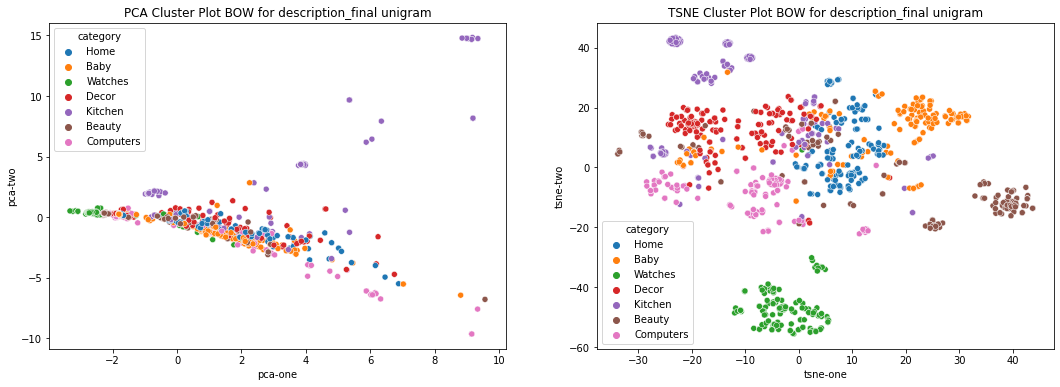

In [ ]:
plot_tsne_pca(tf_matrix_DF.todense(),'BOW_vec for description_final unigram',data['category'])

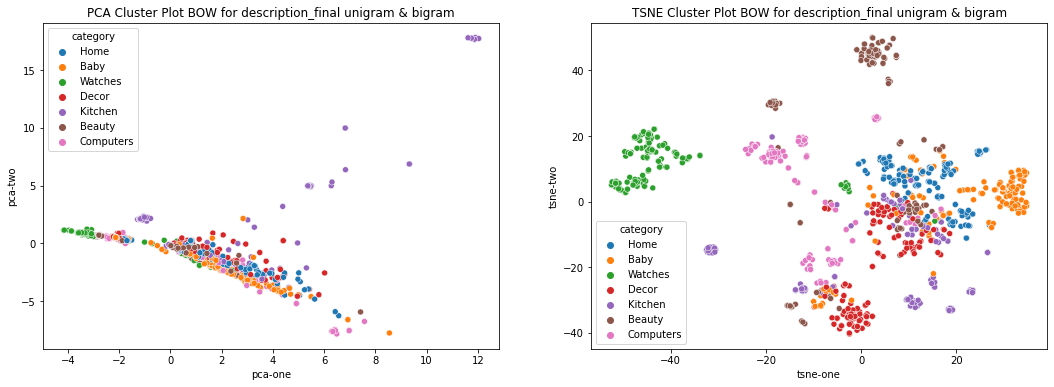

In [ ]:
plot_tsne_pca(tf_matrix_DF_b.todense(),'BOW_vec for description_final unigram & bigram',data['category'])

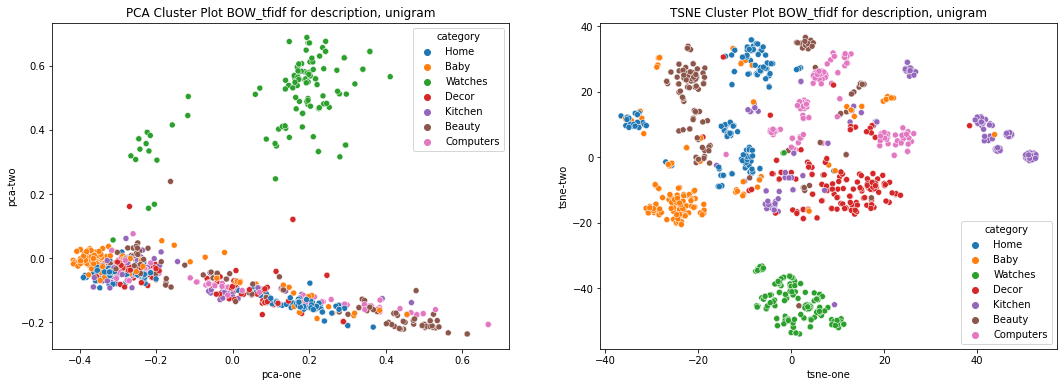

In [ ]:
plot_tsne_pca(tfidf_matrix_DF.todense(),'BOW_tfidf for description, unigram',data['category'])

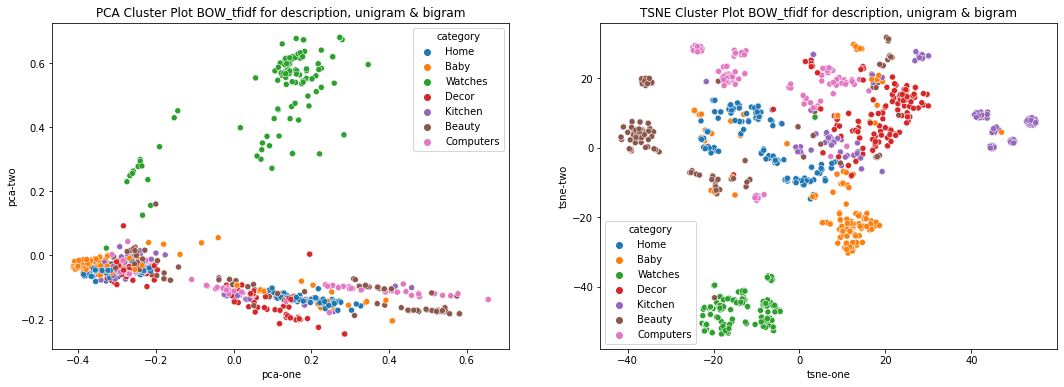

In [ ]:
plot_tsne_pca(tfidf_matrix_DF_b.todense(),'BOW_tfidf for description, unigram & bigram',data['category'])

## Word2Vec

Word2Vec (W2V) is an algorithm that accepts text corpus as an input and outputs a vector representation for each word

https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import tokenize
sentence = [list(tokenize(s, deacc=True, lower=True)) for s in data['description_short_']]
print(sentence[350])
model = Word2Vec(sentence, min_count=500,)
model.corpus_count

['buy', 'tplink', 'wireless', 'nano', 'router', 'flipkart', 'com', 'genuin', 'product', 'day', 'replac', 'guarante', 'free', 'ship', 'cash', 'deliveri']


1050

In [477]:
from gensim.models import Word2Vec
sentences = [list(tokenize(s, deacc=True, lower=True)) for s in data['description_short_']]

# Model
model = Word2Vec(sentences, min_count=15, size=10)
print('model:',model)
print('')

# Vocabulaire
words = list(model.wv.vocab)
print('words:',words)


model: Word2Vec(vocab=612, size=10, alpha=0.025)

words: ['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'height', 'pack', 'price', 'enhanc', 'look', 'interior', 'made', 'high', 'qualiti', 'fabric', 'style', 'metal', 'make', 'room', 'love', 'give', 'home', 'bright', 'design', 'sure', 'smooth', 'morn', 'good', 'world', 'even', 'creat', 'special', 'beauti', 'print', 'bring', 'soft', 'light', 'get', 'right', 'specif', 'general', 'brand', 'type', 'model', 'name', 'set', 'color', 'dimens', 'length', 'box', 'number', 'content', 'sale', 'packag', 'bodi', 'materi', 'cotton', 'bath', 'towel', 'red', 'yellow', 'blue', 'machin', 'washabl', 'yes', 'self', 'gsm', 'ideal', 'men', 'woman', 'boy', 'girl', 'size', 'inch', 'width', 'face', 'small', 'piec', 'exclus', 'export', 'product', 'care', 'skin', 'feel', 'last', 'year', 'fine', 'absorb', 'durabl', 'note', 'may', 'vari', 'pictur', 'wash', 'cold', 'water', 'iron', 'bleach', 'flat', 'dri', 'use', 

In [478]:
word_ = 'color'

# Vecteur pour un mot
print(model[word_])

[-0.05558397  0.553346   -0.26901987  1.0418181  -1.8145863   0.69075847
 -0.19303061 -0.801851   -1.3191274  -0.31549576]


In [ ]:
model.most_similar(word_, topn=10)

[('bodi', 0.9923173785209656),
 ('leg', 0.9864658117294312),
 ('polyest', 0.9834884405136108),
 ('half', 0.9833611249923706),
 ('machin', 0.9819052219390869),
 ('regular', 0.9816858172416687),
 ('yes', 0.9803219437599182),
 ('pot', 0.9776343107223511),
 ('addit', 0.9775291681289673),
 ('name', 0.9770057201385498)]

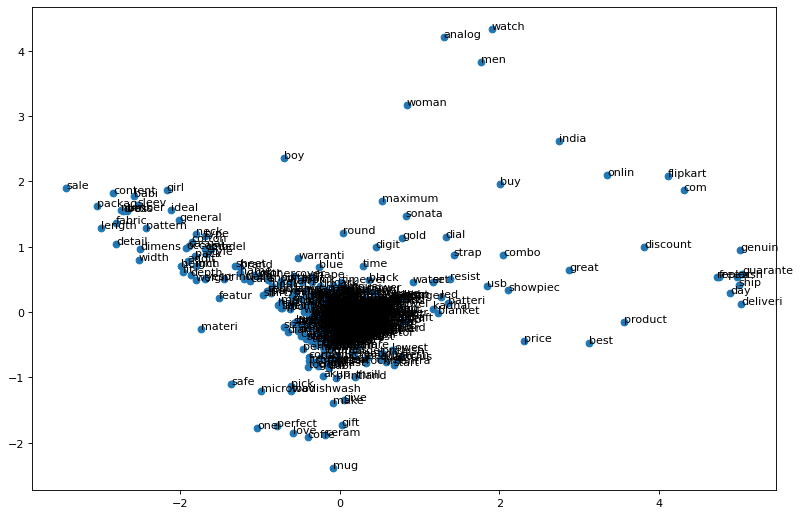

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')


X = model[model.wv.vocab]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Figure
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

In [ ]:
X.shape

(612, 10)

## Modeling

In [479]:
#W2V
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
  nbw= len(phrase.split())
  return sum(get_vect(w, model) for w in phrase)/nbw
    
def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

#X_emb_N = word2vec_features(data['name_clean'].copy(), model)
#X_emb_NF = word2vec_features(data['name_fin'].copy(), model)

X_emb_DF = word2vec_features(data['description_short_'].copy(), model)

X_emb_DF.shape

(1050, 10)

Non-Negative Matrix Factorization (**NMF**). ... This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

**LDA** ( short for Latent Dirichlet Allocation ) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic. A topic is represented as a weighted list of words

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

**SVD** (Singular Value Decomposition) is a widely used technique to decompose a matrix into several component matrices, exposing many of the useful and interesting properties of the original matrix.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [538]:
k=7#nbr of cluster
def kmeans_clustering(tfidf_matrix,tf_matrix,k):

    # Singular Value Decomposition
    svd = TruncatedSVD(n_components=100)

    svd_tfidf = svd.fit_transform(tfidf_matrix_DF)
    svd_tf = svd.fit_transform(tf_matrix_DF)

    km_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(tfidf_matrix_DF) 
    km_tf = KMeans(n_clusters = k,init = 'random', n_init = 50, random_state = 24, algorithm = 'full').fit(tf_matrix_DF)
   
    km_svd_tf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tfidf)# svd-based k-means 
    km_svd_tfidf = KMeans(n_clusters = k,init = 'random' , n_init = 50, random_state = 24, algorithm = 'full').fit(svd_tf) 

    return km_tfidf, km_tf, km_svd_tf, km_svd_tfidf

In [ ]:
#nmf_matrix_N, lda_tf_N, km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N=kmeans_clustering(tfidf_matrix_1,tf_matrix_1,X_emb_N,k=7)
#nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF=kmeans_clustering(tfidf_matrix_2,tf_matrix_2 ,X_emb_NF,k=7)

In [481]:

lda = LatentDirichletAllocation(7, max_iter=5, learning_method='online',learning_offset=50.,random_state=24,)
lda_tf = lda.fit_transform(tf_matrix_DF)
lda_tf


array([[0.00137854, 0.06403937, 0.00137609, ..., 0.0013747 , 0.92907762,
        0.00137731],
       [0.00260003, 0.00260058, 0.00260425, ..., 0.00260498, 0.22489684,
        0.76209269],
       [0.05997294, 0.00129488, 0.01985392, ..., 0.00129127, 0.44643651,
        0.46985705],
       ...,
       [0.30704831, 0.00714565, 0.00715268, ..., 0.6572175 , 0.00714484,
        0.00714428],
       [0.41124472, 0.00649596, 0.00649707, ..., 0.55627549, 0.00649523,
        0.00649476],
       [0.34337904, 0.00714573, 0.00714807, ..., 0.62089132, 0.00714482,
        0.00714425]])

In [ ]:
lda_tf_DF

array([[0.00137854, 0.06403937, 0.00137609, ..., 0.0013747 , 0.92907762,
        0.00137731],
       [0.00260003, 0.00260058, 0.00260425, ..., 0.00260498, 0.22489684,
        0.76209269],
       [0.05997294, 0.00129488, 0.01985392, ..., 0.00129127, 0.44643651,
        0.46985705],
       ...,
       [0.30704831, 0.00714565, 0.00715268, ..., 0.6572175 , 0.00714484,
        0.00714428],
       [0.41124472, 0.00649596, 0.00649707, ..., 0.55627549, 0.00649523,
        0.00649476],
       [0.34337904, 0.00714573, 0.00714807, ..., 0.62089132, 0.00714482,
        0.00714425]])

In [539]:
# unigram
km_tfidf_D,  km_tf_D, km_svd_tf_D,  km_svd_tfidf_D =  kmeans_clustering(tfidf_matrix_D,tf_matrix_D,k=7)
km_tfidf_DF, km_tf_DF, km_svd_tf_DF, km_svd_tfidf_DF = kmeans_clustering(tfidf_matrix_DF,tf_matrix_DF,k=7)

In [540]:
# uni & bigram
km_tfidf_D_b,  km_tf_D_b, km_svd_tf_D_b,  km_svd_tfidf_D_b =  kmeans_clustering(tfidf_matrix_D_b,tf_matrix_D_b,k=7)
km_tfidf_DF_b, km_tf_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b = kmeans_clustering(tfidf_matrix_DF_b,tf_matrix_DF_b,k=7)

In [541]:
def data_cluster(km_tfidf, km_tf, km_svd_tf, km_svd_tfidf):
  df = pd.DataFrame(columns=['cluster_svd_tfidf',
                            'cluster_svd_tf',
                            'cluster_tfidf',
                            'cluster_tf',], index=range(1050))

  df['cluster_svd_tfidf']=km_svd_tfidf.labels_
  df['cluster_svd_tf']=km_svd_tf.labels_

  df['cluster_tfidf']=km_tfidf.labels_
  df['cluster_tf']=km_tf.labels_
  return df

In [542]:
# uni

#df_name=data_cluster(nmf_matrix_N,lda_tf_N,km_tfidf_N,km_tf_N,km_nmf_N,km_lsa_tf_N,km_lsa_tfidf_N,km_lda_N,km_emb_N)
#df_name_final=data_cluster(nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF)

df_desc_vec_u  = data_cluster(km_tfidf_D, km_tf_D, km_svd_tf_D, km_svd_tfidf_D)
df_desc_tfidf_u= data_cluster(km_tfidf_DF, km_tf_DF,km_svd_tf_DF, km_svd_tfidf_DF)

In [544]:
# uni & bi
df_desc_vec_ub  = data_cluster(km_tfidf_D_b,  km_tf_D_b, km_svd_tf_D_b,  km_svd_tfidf_D_b)
df_desc_tfidf_ub= data_cluster(km_tfidf_DF_b, km_tf_DF_b, km_svd_tf_DF_b, km_svd_tfidf_DF_b)

In [545]:
def Ari_score (df,label,label_tru):
  cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

  # Prep
  k_labels = df[label].map(cluster)  # Get cluster labels
  k_labels_matched = np.empty_like(k_labels)

  # For each cluster label...
  for k in np.unique(k_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(label_tru==t)) for t in np.unique(label_tru)]
    k_labels_matched[k_labels==k] = np.unique(label_tru)[np.argmax(match_nums)]
  #confusion_matrix
  conf_mat = confusion_matrix(label_tru, k_labels_matched)

  #compute ARI SCORE
  ari_score=adjusted_rand_score(label_tru, k_labels_matched)
  homogeneity=homogeneity_score(label_tru, k_labels_matched)

  return ari_score,homogeneity

In [546]:
def data_ari(df,Title):
    liste=['cluster_svd_tfidf','cluster_svd_tf','cluster_tfidf',
          'cluster_tf']

    ARI=[]
    for cluster in liste:
      ari,homg=Ari_score (df,cluster, data['category'])
      ARI.append([ari,homg])

    df_ari=pd.DataFrame(ARI
                        ,index=[
                        'svd_tfidf_km','svd_tf_km',
                        'tfidf_km',
                        'tf_km'],
                        columns=['ARI_SCORE','Homogeneity_score'])
  
    #display scores of  each Scaler
    tab_score=df_ari.round(3)

    #plot bar each Scaler 
    barWidth = 0.25# the width of the bars

    r1 = np.arange(len(tab_score))
    r2 = [x + barWidth for x in r1]
    fig, ax = plt.subplots(figsize=(8,5))

    rec1=ax.bar(r1,
                tab_score['ARI_SCORE'],
                color='darkorange',
                width=barWidth,
                label='ARI_SCORE')

    for rect in rec1 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')

    # add some text for labels, title and axes ticks
    ax.set_title('Comparaison des performances Kmeans'+' '+Title, fontsize = 20)
    ax.set_xlabel('Models', fontsize = 15)
    ax.set_ylabel('Scores', fontsize = 15)
    ax.set_ylim(top=1)
    plt.xticks(r1, tab_score.index)
    ax.legend()
    plt.show()

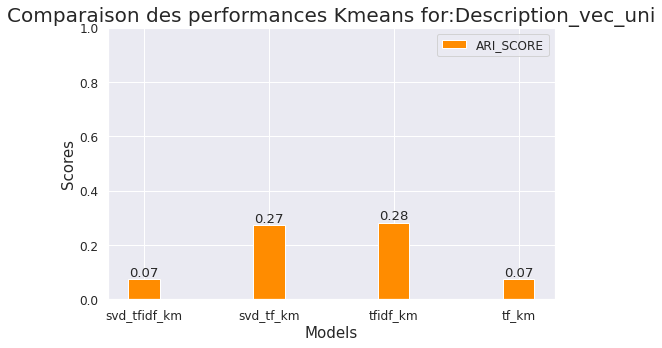

In [547]:
data_ari(df_desc_vec_u,'for:Description_vec_uni')

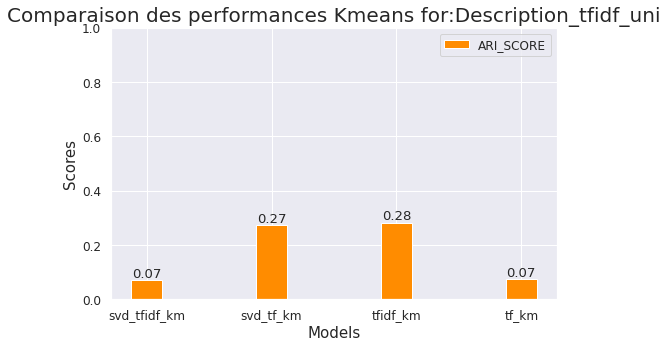

In [527]:
data_ari(df_desc_tfidf_u,'for:Description_tfidf_uni')

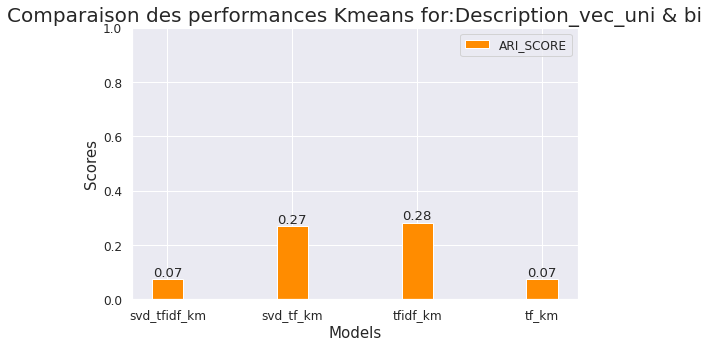

In [528]:
data_ari(df_desc_vec_ub,'for:Description_vec_uni & bi')

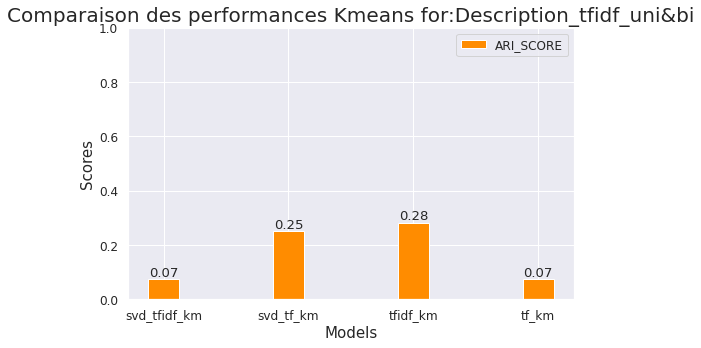

In [529]:
data_ari(df_desc_tfidf_ub,'for:Description_tfidf_uni&bi')

## Traitement des images

In [ ]:
from PIL import Image, ImageOps
ima_id = '0ae859a69c7608d8197c3ba8c37bc6ec'
# Chargement de l'image en mémoire
img0 = Image.open('/content/drive/MyDrive/p6/image/'+ima_id+'.jpg')

# Sauvegarde de l'image sur le disque dans le répertoire images_processed
img0.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_0.jpg', 'jpeg')

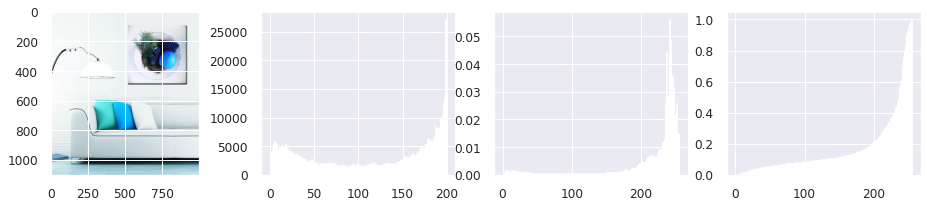

In [ ]:
# Transformation de l'image en matrice de pixels
img0_num = np.array(img0)

# Histogrammes
plt.figure(figsize=(16,3))
plt.subplot(141),plt.imshow(img0)
plt.subplot(142),plt.hist(img0_num.flatten(), bins=range(256)) # Histogramme
plt.subplot(143),plt.hist(img0_num.flatten(), bins=range(256), density=True) # Histogramme normalisé
plt.subplot(144),plt.hist(img0_num.flatten(), bins=range(256), density=True, cumulative=True) # Histogramme normalisé cumulé
plt.show()

In [ ]:
gray_ = 1

if gray_ == 1:
    img1 = img0.convert('L')
elif gray_ == 0:
    img1 = img0 

In [ ]:
img1_num = np.array(img1)
img1.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_1.jpg', 'jpeg')

In [ ]:
from PIL import ImageFilter

# Lissage par moyennage (fenêtre de taille 9)
img2a = img1.filter(ImageFilter.BoxBlur(1))
img2a_num = np.array(img2a)
img2a.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_2a.jpg', 'jpeg')

In [ ]:
# Filtre gaussien
img2b = img1.filter(ImageFilter.GaussianBlur(1))
img2b_num = np.array(img2b)
img2b.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_2b.jpg', 'jpeg')

In [ ]:
# Egalisation après réduction de bruit méthode 1
img3a = ImageOps.equalize(img2a, mask = None)
img3a_num = np.array(img3a)
img3a.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_3a.jpg', 'jpeg')

In [ ]:
# Egalisation après réduction de bruit méthode 2
img3b = ImageOps.equalize(img2b, mask = None)
img3b_num = np.array(img3b)
img3b.save('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_A_3b.jpg', 'jpeg')

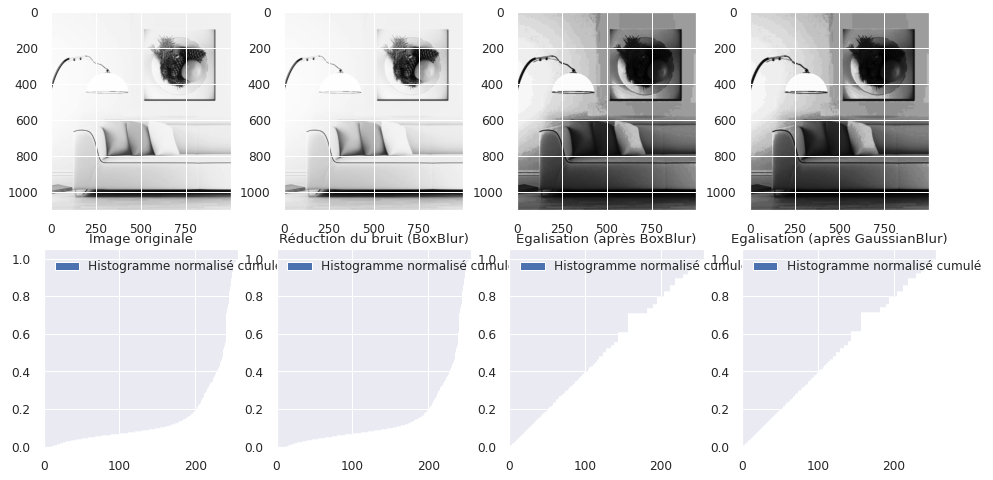

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(241),plt.imshow(img1, cmap='gray')
plt.subplot(242),plt.imshow(img2a, cmap='gray')
plt.subplot(243),plt.imshow(img3a, cmap='gray')
plt.subplot(244),plt.imshow(img3b, cmap='gray')

plt.subplot(245),plt.hist(img1_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Image originale')

plt.subplot(246),plt.hist(img2a_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Réduction du bruit (BoxBlur)')

plt.subplot(247),plt.hist(img3a_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Egalisation (après BoxBlur)')

plt.subplot(248),plt.hist(img3b_num.flatten(), bins=range(256), density=True, cumulative=True),
plt.xlim([0,256])
plt.legend(['Histogramme normalisé cumulé'], loc = 'upper left')
plt.title('Egalisation (après GaussianBlur)')

plt.show()

Prétraitement des images avec OpenCV

In [ ]:
import cv2
print('cv2',cv2.__version__)

cv2 4.1.2


In [ ]:
img0 = cv2.imread('/content/drive/MyDrive/p6/image/'+ima_id+'.jpg') # On charge l'image en couleur en mémoire

In [ ]:
gray_ = 0

if gray_ == 1:
    img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY) # Conversion de l'image originale (couleur) en niveaux de gris
    
    # Format d'affichage:
      # L'image sera affichée en niveaux de gris inversés, on la redressera avec le paramètre cmap='gray'
    img1_ = img1
    
elif gray_ == 0:
    img1 = img0 # Image en couleur
    
    # Format d'affichage:
      # cv2 traite les images en mode BGR
      # Le processus de traitement d'une image native RGB se fait donc en mode BGR
      # L'image traitée sauvegardée sur disque sera rendue dans le format original, donc RGB
      # Par contre, l'affiche de l'image en cours de processus sera exécuté en mode BGR
      # Il est donc nécessaire d'ajouter une étape préliminaire à l'affichage avec la méthode cvtcolor

    img1_ = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Transformation BGR --> RGB

In [ ]:
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_1.jpg', img1) # On sauvegarde l'image sur le disque
                                                                          # dans le répertoire images_processed

True

In [ ]:
hist,bins = np.histogram(img1.flatten(),256,[0,256])
cdf1 = hist.cumsum()
cdf1_normalized = cdf1 * hist.max() / cdf1.max()

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_1.jpg')

if gray_ == 1:
    img2 = cv2.fastNlMeansDenoising(img1,None,5,7,21) # Image en niveaux de gris
    img2_ = img2
elif gray_ == 0:
    img2 = cv2.fastNlMeansDenoisingColored(img1,None,5,5,7,21) # Image en BGR
    img2_ = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # Image en RGB (pour affichage)
    
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg', img2)

True

In [ ]:
hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf2 = hist.cumsum()
cdf2_normalized = cdf2 * hist.max() / cdf2.max()

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg',0)

img3a = cv2.equalizeHist(img2)
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_3a.jpg', img3a)

# Après égalisation, l'image est rendue en niveaux de gris
# Les niveaux sont inversés à l'affichage
# On utilisera donc le paramètre cmap ='gray' pour rétablir les niveaux

True

In [ ]:
hist,bins = np.histogram(img3a.flatten(),256,[0,256])
cdf3a = hist.cumsum()
cdf3a_normalized = cdf3a * hist.max() / cdf3a.max()

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_2.jpg',0)

# On créé un objet CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img3b = clahe.apply(img2)
cv2.imwrite('/content/drive/MyDrive/p6/images_processed/'+ima_id+'_B_3b.jpg', img3b)

True

In [ ]:
hist,bins = np.histogram(img3b.flatten(),256,[0,256])
cdf3b = hist.cumsum()
cdf3b_normalized = cdf3b * hist.max() / cdf3b.max()

Text(0.5, 1.0, 'Egalisation (clahe)')

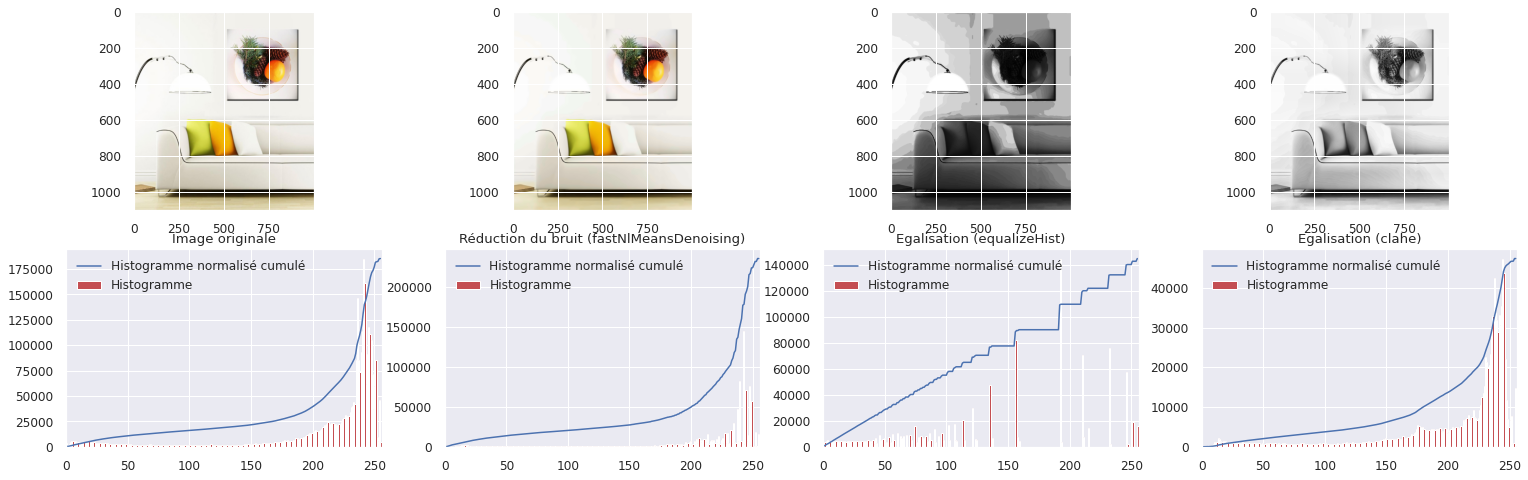

In [ ]:
plt.figure(figsize=(26,8))

if gray_ == 1: 
    plt.subplot(241),plt.imshow(img1_, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(242),plt.imshow(img2_)
    plt.subplot(243),plt.imshow(img3a, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(244),plt.imshow(img3b, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap

elif gray_ == 0:
    plt.subplot(241),plt.imshow(img1_) # Image affichée en RGB
    plt.subplot(242),plt.imshow(img2_) # Image affichée en RGB
    plt.subplot(243),plt.imshow(img3a, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    plt.subplot(244),plt.imshow(img3b, cmap='gray') # Image affichée en niveaux de gris inversés, on la redresse avec cmap
    
plt.subplot(245)
plt.plot(cdf1_normalized,color='b')
plt.hist(img1.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Image originale')

plt.subplot(246)
plt.plot(cdf2_normalized,color='b')
plt.hist(img2.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Réduction du bruit (fastNlMeansDenoising)')

plt.subplot(247)
plt.plot(cdf3a_normalized,color='b')
plt.hist(img3a.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Egalisation (equalizeHist)')

plt.subplot(248)
plt.plot(cdf3b_normalized,color='b')
plt.hist(img3b.flatten(),256,[0,256],color='r')
plt.xlim([0,256])
plt.legend(('Histogramme normalisé cumulé','Histogramme'), loc = 'upper left')
plt.title('Egalisation (clahe)')


In [ ]:
img1_num = np.array(img1)
img1.save('../OCDS_Projet_6/images_processed/'+ima_id+'_A_1.jpg', 'jpeg')